# Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

# Load Data

In [7]:
import warnings

warnings.filterwarnings('ignore')

# Function to load all participants
df_good = pd.read_csv('../../02_analysis/df_good.csv')

# df = subject_df(df=df_good, sub_num=0)

# Next Day Gap

# Moving Average: Next 3 Days

## Simple Moving Average

In [8]:
# Define a function to calculate the 3-day moving average with forward-looking window
def forward_moving_average(series, window=3):
    return series.rolling(window=window, min_periods=1).mean().shift(-window)

# Apply the moving average calculation for each PID
df_good['target'] = df_good.groupby('PID')['sr_gap_heuristic'].transform(lambda x: forward_moving_average(x, window=3))

In [18]:
df_good[['target', 'sr_gap_heuristic', 'PID', 'trial_date']].iloc[1100:1110]

target  sr_gap_heuristic                                   PID  \
1100  31.700000             18.75  146e1ab8-c4ca-4a52-9261-e108b38eea53   
1101  48.750000             14.65  146e1ab8-c4ca-4a52-9261-e108b38eea53   
1102        NaN             48.75  146e1ab8-c4ca-4a52-9261-e108b38eea53   
1103        NaN               NaN  146e1ab8-c4ca-4a52-9261-e108b38eea53   
1104        NaN               NaN  146e1ab8-c4ca-4a52-9261-e108b38eea53   
1105  37.333333             66.00  147400db-43d9-4155-8bf2-b85b8adf4315   
1106  28.216667             53.70  147400db-43d9-4155-8bf2-b85b8adf4315   
1107  33.750000             32.15  147400db-43d9-4155-8bf2-b85b8adf4315   
1108  36.283333             26.15  147400db-43d9-4155-8bf2-b85b8adf4315   
1109  43.933333             26.35  147400db-43d9-4155-8bf2-b85b8adf4315   

      trial_date  
1100  2022-12-16  
1101  2022-12-17  
1102  2022-12-18  
1103  2022-12-19  
1104  2022-12-20  
1105  2022-09-27  
1106  2022-09-28  
1107  2022-09-29  
1108  2022-09-30  
1109  2022-10-01

## Exponential Moving Average

The multiplier for smoothing (weighting) the EMA, which typically follows the formula: $[2 รท (\text{number of observations} + 1)]$

In our case with 3 observations:

$$[2 รท (3 + 1)] = 0.5$$

In [142]:
# Define a function to calculate the weighted moving average within a window, handling NA values
def windowed_exponential_moving_average(window):
    alpha = 2 / (len(window) + 1)  # Calculate alpha (doesn't change if NAs)
    
    # Return NA if the window is empty after removing NA values
    if len(window[~np.isnan(window)]) == 0:
        return np.nan 
    # Return NA if the current day value is NA (we should not be estimating a target value based only on following days)
    if np.isnan(window[-1]):
        return np.nan
    weights = np.array([alpha * (1 - alpha) ** i for i in range(len(window))])
    weights = weights[::-1]  # Reverse weights to apply more weight to recent values
    
    # Weights that correspond to nan values should be set to 0
    nan_mask = np.isnan(window)
    weights[nan_mask] = 0 
    # Replace NaN values in window with zero (i.e. they will not be used in sum)
    window = np.nan_to_num(window)
    
    return np.dot(window, weights) / weights.sum()

In [136]:
def forward_moving_average_exp(series, window_size):
    windowed_ema = pd.Series(series[::-1]).rolling(window=window_size, min_periods=1).apply(windowed_exponential_moving_average, raw=True)
    # Reverse and set next day value for current day
    windowed_ema = windowed_ema[::-1].shift(-1)
    return windowed_ema

# Apply the moving average calculation for each PID
df_good['target_exp'] = df_good.groupby('PID')['sr_gap_heuristic'].transform(lambda x: forward_moving_average_exp(x, window_size=3))

In [139]:
df_good[['target_exp', 'sr_gap_heuristic', 'PID']].iloc[80:90]

target_exp  sr_gap_heuristic                                   PID
80   22.992857              4.05  0151d9f1-1644-4437-805e-02f5e244a690
81   27.650000             19.50  0151d9f1-1644-4437-805e-02f5e244a690
82   19.050000             31.95  0151d9f1-1644-4437-805e-02f5e244a690
83         NaN             19.05  0151d9f1-1644-4437-805e-02f5e244a690
84         NaN               NaN  0151d9f1-1644-4437-805e-02f5e244a690
85   42.000000              0.00  02f48bee-6e86-437c-9394-10ae57dadd14
86   49.850000             39.50  02f48bee-6e86-437c-9394-10ae57dadd14
87         NaN             47.00  02f48bee-6e86-437c-9394-10ae57dadd14
88   60.600000               NaN  02f48bee-6e86-437c-9394-10ae57dadd14
89   54.842857             61.25  02f48bee-6e86-437c-9394-10ae57dadd14

In [140]:
(19.5 * .5714 + 31.95 * .2857 + 19.05 * .1429)

22.99266

In [141]:
(31.95 * .5714 + 19.05 * .2857 + 0 * .1429) / (.5714 + .2857)

27.650000000000002

## Visualize

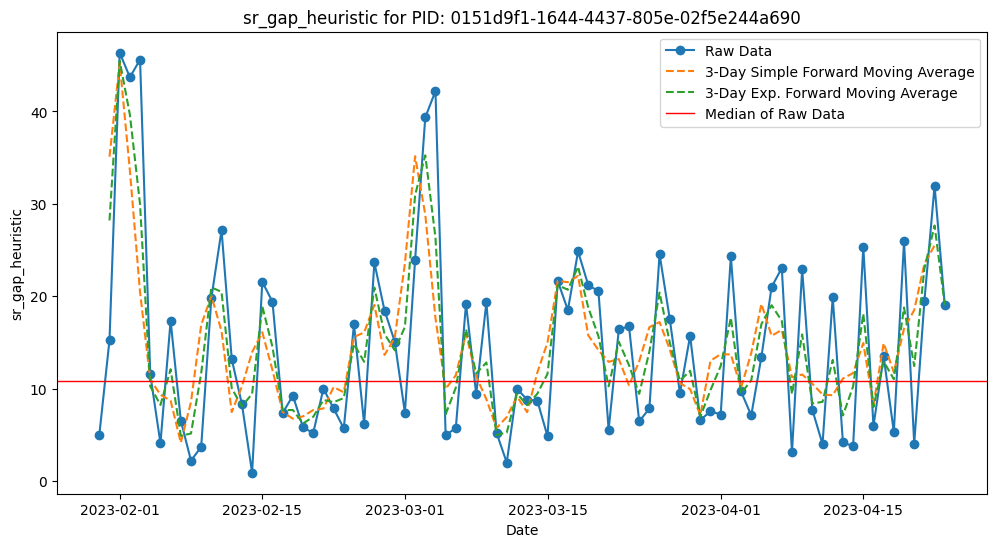

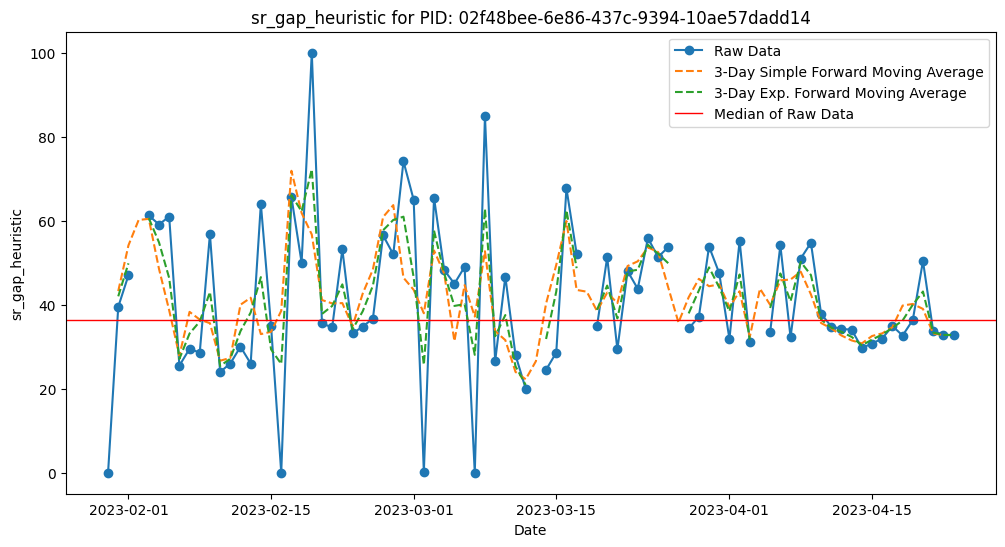

In [143]:
# Visualize a couple subjects with both original and three day smoothed gap

# This is not the same as the target as it is the average of [current day, cd+1, cd+2]
# The target column created is the average of [cd+1, cd+2, cd+3]

# Selecting two PIDs
pids = df_good['PID'].unique()[:3]

# Filter the dataframe for the two PIDs
df_filtered = df_good[df_good['PID'].isin(pids)][['PID', 'trial_date', 'sr_gap_heuristic', 'target', 'target_exp']]

# Ensure the trial_date is in datetime format
df_filtered['trial_date'] = pd.to_datetime(df_filtered['trial_date'])

# Sort by trial_date for each PID
df_filtered = df_filtered.sort_values(by=['PID', 'trial_date'])

# Plot the data for each PID
for pid in pids:
    df_pid = df_filtered[df_filtered['PID'] == pid]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_pid['trial_date'], df_pid['sr_gap_heuristic'], label='Raw Data', marker='o')
    plt.plot(df_pid['trial_date'], df_pid['target'].shift(1), label='3-Day Simple Forward Moving Average', linestyle='--')
    plt.plot(df_pid['trial_date'], df_pid['target_exp'].shift(1), label='3-Day Exp. Forward Moving Average', linestyle='--')
    
    # Add a horizontal line at the median of the raw data
    median_value = df_pid['sr_gap_heuristic'].median()
    plt.axhline(median_value, color='red', linestyle='-', linewidth=1, label='Median of Raw Data')
    
    plt.title(f'sr_gap_heuristic for PID: {pid}')
    plt.xlabel('Date')
    plt.ylabel('sr_gap_heuristic')
    plt.legend()
    plt.show()